Block encoding is a technique to encode a non-unitary matrix A on a quantum circuit.
In order to that a larger matrix $U_A$ is employed.
$$ U_A = 
\begin{bmatrix}
A & * \\
* & *
\end{bmatrix}
$$

Here we want to encode the nonunitary matrix $ A =\begin{bmatrix}
1/2 & 1/4 \\
1/4 & 1/2
\end{bmatrix} $ and perform the operation $ v = Ax $.
\
If the vector x is $ x = [0, 1]^T $ then $ v = [1/4, 1/2] $
The resulting vector has the coeffients in squared form: $v_{0}^2=\frac{1}{16} , v_{1}^2=\frac{1}{4}$
With the following ratio : $v_1^2/v_0^2=4$

Due to block encoding $A$ will be encoded as $A/s$ where $s=2$ so in the final result we will get
$ w=1/s \cdot v = 1/s \cdot Ax=[1/8, 1/4] $ but the ratio of the squared coeffients will always be 4.

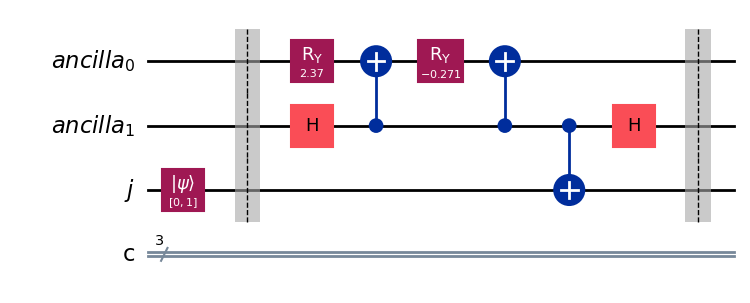

In [12]:
# Imports
from qiskit.compiler import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
import numpy as np


# print(A*A)
# print(A[0,0])
alpha_1 = 1/2 # 0<alpha<1
alpha_2 = 1/4 # 0<alpha<1
phi_1 = np.arccos(alpha_1)+np.arccos(alpha_2)
phi_2 = np.arccos(alpha_1)-np.arccos(alpha_2)
A = np.matrix([[alpha_1, alpha_2], [alpha_2, alpha_1]])

# Create the various registers needed
input = QuantumRegister(1, name='j')
ancilla = QuantumRegister(2, name='ancilla')
measurement = ClassicalRegister(3, name='c')



# Create an empty circuit with the specified registers
circuit = QuantumCircuit(ancilla, input, measurement)


vector = [0,1] # Note: this vector is already normalized
initial_state = vector/np.linalg.norm(vector)
circuit.initialize(initial_state, 2)  

circuit.barrier()
circuit.h(1)

circuit.draw('mpl')
circuit.ry(phi_1, 0)
circuit.cx(1,0)
circuit.ry(phi_2, 0)
circuit.cx(1,0)
circuit.cx(1,2)
circuit.h(1)
circuit.barrier()

circuit.draw('mpl')

In [13]:
from qiskit.quantum_info import Statevector
#### Optional part ####
# Set the initial state of the simulator to the ground state using from_int
# and check the results
state = Statevector.from_int(0, 2**3)
# Evolve the state by the quantum circuit
state = state.evolve(circuit)
#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

In [14]:
circuit.measure(0,0)  # ancilla 0
circuit.measure(1, 1) # ancilla 1
circuit.measure(2, 2) # qubit where the vector of interest is encoded

backend = AerSimulator() # Quantum circuit simulator backend

# Circuit transpilation to QASM instructions supported by the backend
qc_compiled = transpile(circuit, backend)

# Execute the compiled circuit on the qasm simulator.
shots = 100000
job_sim = backend.run(qc_compiled, shots=shots)

# Grab the results from the job.
result_sim = job_sim.result()
counts = result_sim.get_counts(qc_compiled)

# only if ancilla 0 and ancilla 1 are both 0 we get Ax on the qubit

# Note: in this circuit there are three qubits
# q_0 = ancilla 0
# q_1 = ancilla 1
# q_2 = j
# That are ordered like this in the results: ['q_2 q_1 q_0']
# So q_2 is the Most Significant "bit" and q_0 is the Least Significant "bit"
# This is the standard convention in qiskit.
x_0 = counts['000']
x_1 = counts['100']

# We get a result which is close to 4
print(x_1/x_0)

4.051314945477871


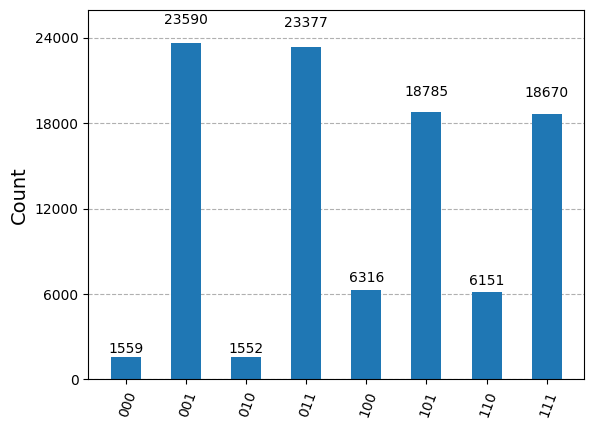

In [15]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)